# Lab 7.2 Fine-Tuning

In this notebook you will explore fine-tuning a CNN to classify pet breeds.

Here is some code to download a prepared version of the [Oxford-IIIT Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [1]:
import os
if not os.path.exists('oxford_pets.zip'):
  !wget "https://www.dropbox.com/scl/fi/p49ifha27c2u3uptfj42w/oxford_pets_corrected.zip?rlkey=dwk3dsptzir8v846imsq6bgw3&dl=1" -O oxford_pets.zip
  !unzip -qq oxford_pets.zip

--2025-05-31 14:30:46--  https://www.dropbox.com/scl/fi/p49ifha27c2u3uptfj42w/oxford_pets_corrected.zip?rlkey=dwk3dsptzir8v846imsq6bgw3&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:601b:18::a27d:812, 162.125.8.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:601b:18::a27d:812|:443... connected.
ERROR: cannot verify www.dropbox.com's certificate, issued by ‘CN=DigiCert TLS RSA SHA256 2020 CA1,O=DigiCert Inc,C=US’:
  Unable to locally verify the issuer's authority.
To connect to www.dropbox.com insecurely, use `--no-check-certificate'.
[oxford_pets.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of oxford_pets.zip or
        oxford_pets.zip.zip, and cannot find oxford_pets.zip.ZIP, period.


In [ ]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import os
import certifi
import tensorflow as tf
from tensorflow import keras

In [13]:
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Exercises

1. Set up the data loaders.

- Use `keras.utils.image_dataset_from_directory` to create training, validation and test datasets.  
- Set the image size to (224,224) and use a validation split of 0.1.
- Remember to use the same random seed for training and validation splits.

In [31]:
train_dir = 'oxford_pets/train'
test_dir = 'oxford_pets/test'

seed = 2025
img_size = (224, 224)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# 2. Load the separate 'test' folder (no split needed)
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 6639 files belonging to 35 classes.
Using 5976 files for training.
Found 6639 files belonging to 35 classes.
Using 663 files for validation.
Found 739 files belonging to 35 classes.


2. Create a `Sequential` model with the pre-trained `VGG16` network.

The model should have the following layers:
- Input layer
- One or more [data augmentation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/) layers such as `RandomFlip`, `RandomZoom`, `RandomRotation`, etc.
- VGG16 preprocess function inside a `Lambda` layer
- VGG16 layer: don't include top; use `max` pooling.
- Dense layer with 35 outputs and correct activation function for multi-class classification

In [32]:
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

os.environ["SSL_CERT_FILE"] = certifi.where()

num_classes = len(train_ds.class_names)

input_shape = (224, 224, 3)

model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Lambda(preprocess_input),
    VGG16(
        weights='imagenet',
        include_top=False,
        pooling='max',
        input_shape=input_shape
    ),
    layers.Dense(35, activation='softmax'),
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │        17,955 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,732,643 (56.20 MB)

 Trainable params: 14,732,643 (56.20 MB)

 Non-trainable params: 0 (0.00 B)

Set the VGG16 part of the network to be fixed by setting the `trainable` attribute of VGG16 layer to `False`.  (You can access the layers of the model with `model.layers`.)

In [33]:
model.layers[5].trainable = False

Check the model summary to make sure that the VGG16 layer is trainable (it should report a very large number of non-trainable parameters, and a small number of trainable parameters.)


In [34]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 35)             │        17,955 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,732,643 (56.20 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 17,955 (70.14 KB)

Compile the model with multi-class classification loss and accuracy metric.  You can use Adam with learning rate 3e-4.

In [36]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

4. Evaluate the model on the test set and check that the accuracy is about $1/35=.029$.

In [38]:
test_loss, test_acc = model.evaluate(test_ds)

print(f"Test accuracy: {test_acc:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.0395 - loss: 15.3511
Test accuracy: 0.0379


5. Now train the model on the training set (don't forget to include the validation set) for 20 epochs.

In [39]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
 12/187 ━━━━━━━━━━━━━━━━━━━━ 2:41 924ms/step - accuracy: 0.0330 - loss: 15.5858

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


140/187 ━━━━━━━━━━━━━━━━━━━━ 42s 895ms/step - accuracy: 0.0268 - loss: 15.6691

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 177s 919ms/step - accuracy: 0.0267 - loss: 15.6638 - val_accuracy: 0.0196 - val_loss: 15.1771
Epoch 2/20
 39/187 ━━━━━━━━━━━━━━━━━━━━ 2:11 886ms/step - accuracy: 0.0339 - loss: 15.5497

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


162/187 ━━━━━━━━━━━━━━━━━━━━ 22s 887ms/step - accuracy: 0.0295 - loss: 11.8760

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0291 - loss: 11.2306 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 3/20
 16/187 ━━━━━━━━━━━━━━━━━━━━ 2:31 886ms/step - accuracy: 0.0178 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


140/187 ━━━━━━━━━━━━━━━━━━━━ 41s 888ms/step - accuracy: 0.0288 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0285 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 4/20
 15/187 ━━━━━━━━━━━━━━━━━━━━ 2:32 886ms/step - accuracy: 0.0293 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


168/187 ━━━━━━━━━━━━━━━━━━━━ 16s 887ms/step - accuracy: 0.0298 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0295 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 5/20
 14/187 ━━━━━━━━━━━━━━━━━━━━ 2:33 886ms/step - accuracy: 0.0195 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


147/187 ━━━━━━━━━━━━━━━━━━━━ 35s 888ms/step - accuracy: 0.0291 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 912ms/step - accuracy: 0.0287 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 6/20
 21/187 ━━━━━━━━━━━━━━━━━━━━ 2:27 887ms/step - accuracy: 0.0178 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


155/187 ━━━━━━━━━━━━━━━━━━━━ 28s 887ms/step - accuracy: 0.0281 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 910ms/step - accuracy: 0.0280 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 7/20
 33/187 ━━━━━━━━━━━━━━━━━━━━ 2:16 886ms/step - accuracy: 0.0224 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


181/187 ━━━━━━━━━━━━━━━━━━━━ 5s 888ms/step - accuracy: 0.0280 - loss: 3.5554

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0279 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 8/20
 19/187 ━━━━━━━━━━━━━━━━━━━━ 2:29 889ms/step - accuracy: 0.0175 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


153/187 ━━━━━━━━━━━━━━━━━━━━ 30s 887ms/step - accuracy: 0.0284 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0282 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 9/20
 12/187 ━━━━━━━━━━━━━━━━━━━━ 2:34 885ms/step - accuracy: 0.0130 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


146/187 ━━━━━━━━━━━━━━━━━━━━ 36s 886ms/step - accuracy: 0.0283 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 909ms/step - accuracy: 0.0281 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 10/20
 13/187 ━━━━━━━━━━━━━━━━━━━━ 2:34 886ms/step - accuracy: 0.0196 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


142/187 ━━━━━━━━━━━━━━━━━━━━ 39s 887ms/step - accuracy: 0.0285 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 910ms/step - accuracy: 0.0283 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 11/20
 13/187 ━━━━━━━━━━━━━━━━━━━━ 2:34 887ms/step - accuracy: 0.0205 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


142/187 ━━━━━━━━━━━━━━━━━━━━ 39s 887ms/step - accuracy: 0.0289 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0285 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 12/20
 35/187 ━━━━━━━━━━━━━━━━━━━━ 2:14 886ms/step - accuracy: 0.0262 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


147/187 ━━━━━━━━━━━━━━━━━━━━ 35s 887ms/step - accuracy: 0.0289 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 910ms/step - accuracy: 0.0287 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 13/20
 51/187 ━━━━━━━━━━━━━━━━━━━━ 2:00 887ms/step - accuracy: 0.0298 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


145/187 ━━━━━━━━━━━━━━━━━━━━ 37s 886ms/step - accuracy: 0.0295 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 910ms/step - accuracy: 0.0291 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 14/20
 12/187 ━━━━━━━━━━━━━━━━━━━━ 2:35 888ms/step - accuracy: 0.0320 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


156/187 ━━━━━━━━━━━━━━━━━━━━ 27s 887ms/step - accuracy: 0.0293 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0290 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 15/20
 17/187 ━━━━━━━━━━━━━━━━━━━━ 2:30 885ms/step - accuracy: 0.0235 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


147/187 ━━━━━━━━━━━━━━━━━━━━ 35s 887ms/step - accuracy: 0.0293 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 910ms/step - accuracy: 0.0289 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 16/20
 25/187 ━━━━━━━━━━━━━━━━━━━━ 2:23 885ms/step - accuracy: 0.0291 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


140/187 ━━━━━━━━━━━━━━━━━━━━ 41s 887ms/step - accuracy: 0.0299 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0292 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 17/20
 14/187 ━━━━━━━━━━━━━━━━━━━━ 2:32 884ms/step - accuracy: 0.0257 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


144/187 ━━━━━━━━━━━━━━━━━━━━ 38s 886ms/step - accuracy: 0.0297 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 909ms/step - accuracy: 0.0292 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 18/20
 20/187 ━━━━━━━━━━━━━━━━━━━━ 2:28 890ms/step - accuracy: 0.0243 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


142/187 ━━━━━━━━━━━━━━━━━━━━ 39s 887ms/step - accuracy: 0.0292 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 911ms/step - accuracy: 0.0288 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 19/20
 16/187 ━━━━━━━━━━━━━━━━━━━━ 2:31 887ms/step - accuracy: 0.0212 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


145/187 ━━━━━━━━━━━━━━━━━━━━ 37s 886ms/step - accuracy: 0.0290 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 910ms/step - accuracy: 0.0286 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553
Epoch 20/20
 12/187 ━━━━━━━━━━━━━━━━━━━━ 2:35 886ms/step - accuracy: 0.0323 - loss: 3.5553

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


153/187 ━━━━━━━━━━━━━━━━━━━━ 30s 886ms/step - accuracy: 0.0301 - loss: 3.5553

Corrupt JPEG data: premature end of data segment


187/187 ━━━━━━━━━━━━━━━━━━━━ 170s 910ms/step - accuracy: 0.0296 - loss: 3.5554 - val_accuracy: 0.0241 - val_loss: 3.5553


6. Evaluate the accuracy of the fine-tuned model on the test set.

In [40]:
test_loss, test_acc = model.evaluate(test_ds)

print(f"Fine-tuned model test accuracy: {test_acc:.3f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.0955 - loss: 3.5553
Fine-tuned model test accuracy: 0.027


7. The following code will show some test images with the correct and predicted labels.

In [41]:
images, labels = next(iter(test_ds))
preds = model.predict(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


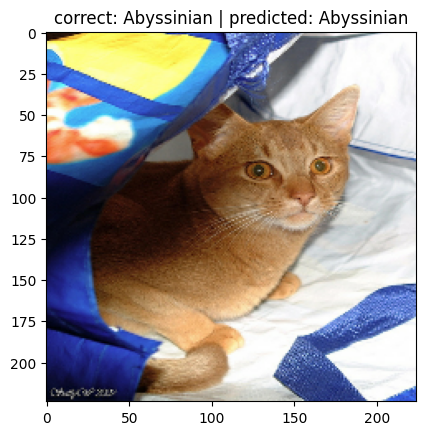

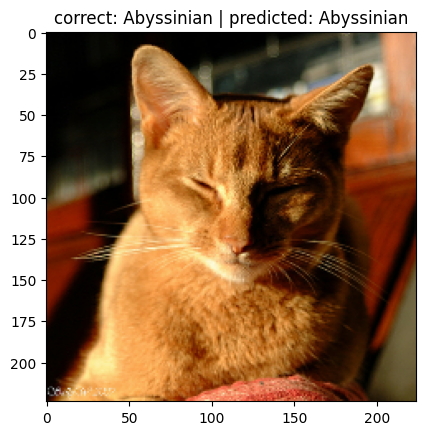

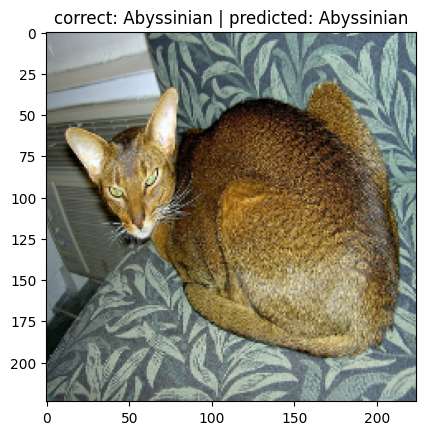

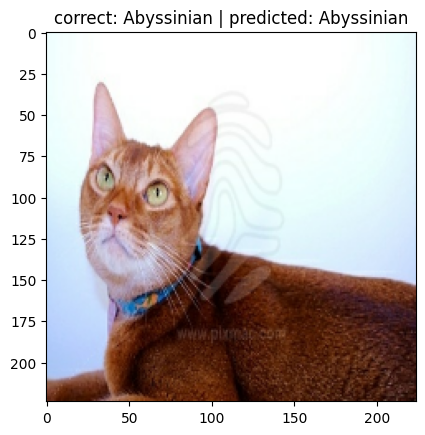

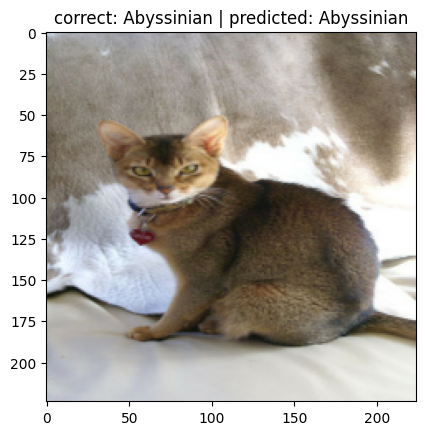

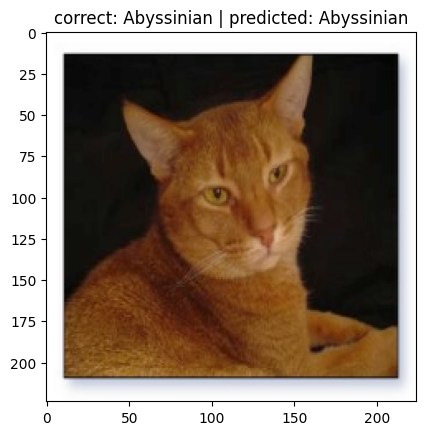

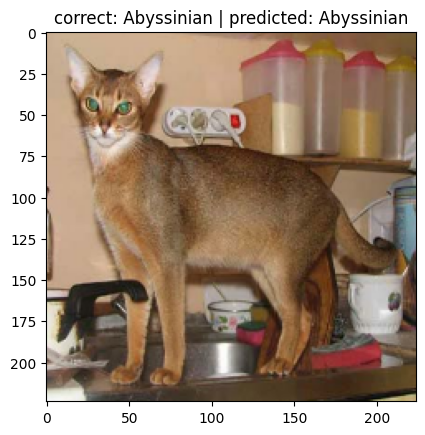

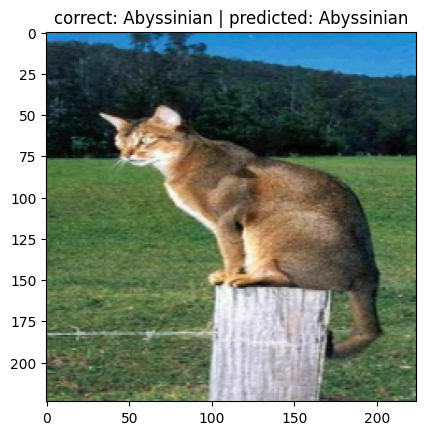

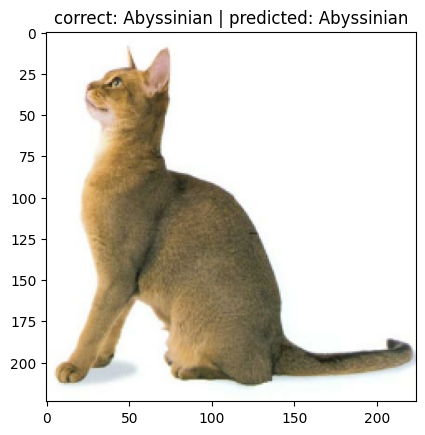

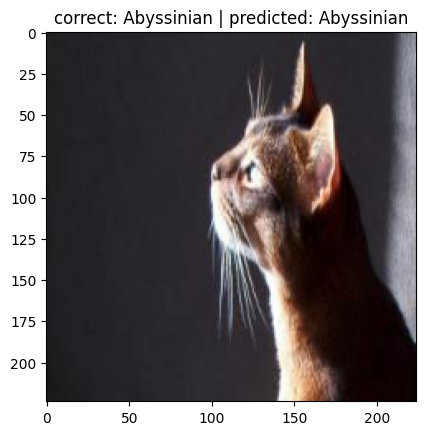

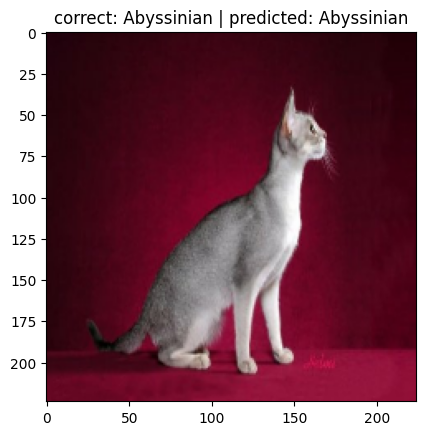

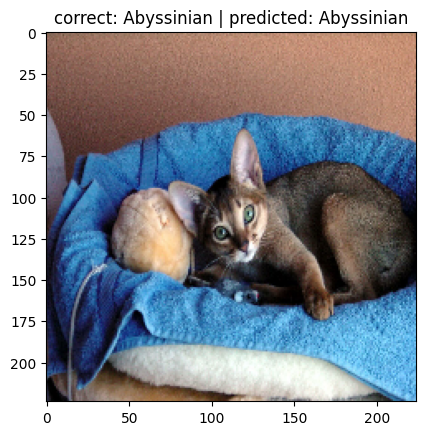

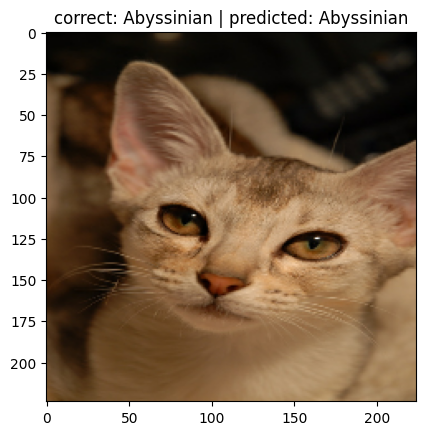

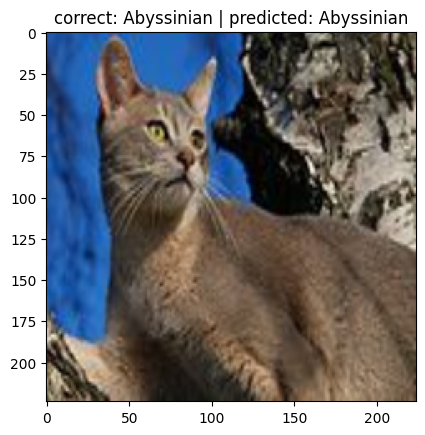

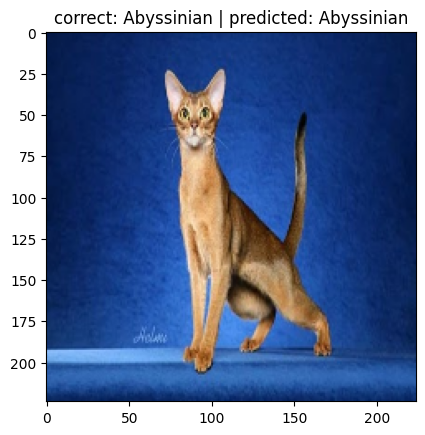

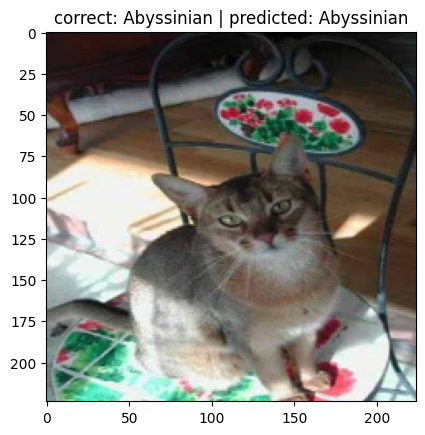

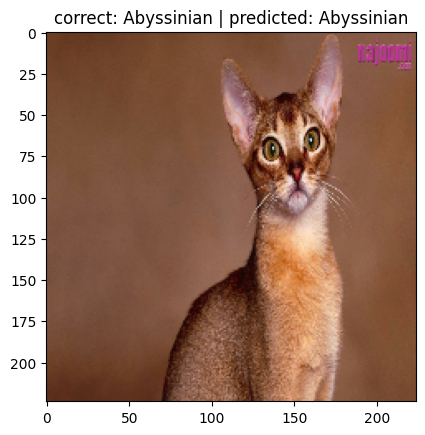

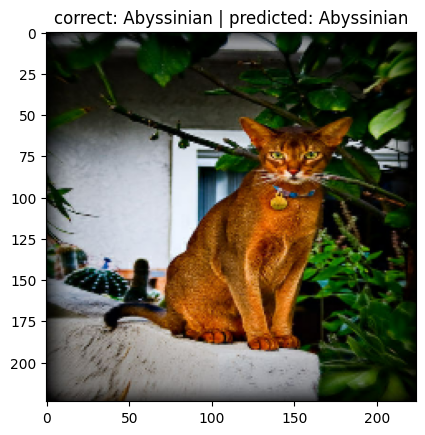

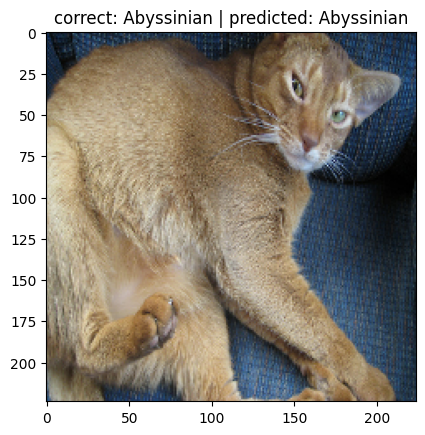

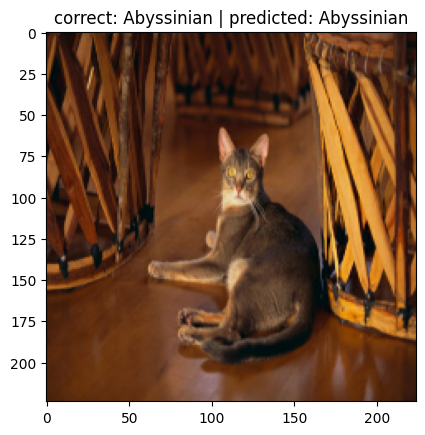

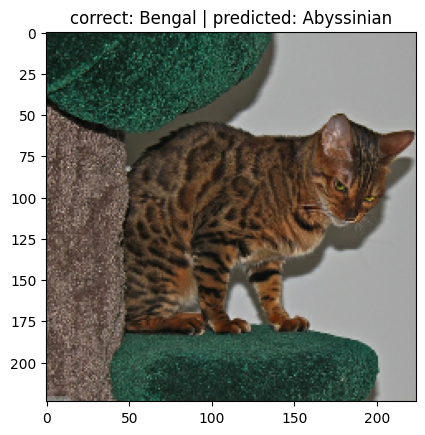

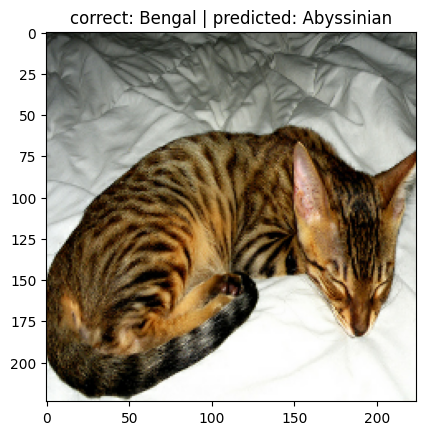

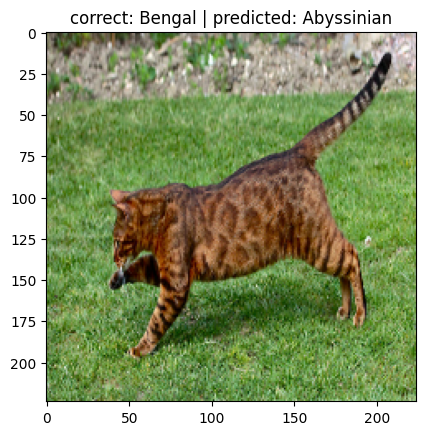

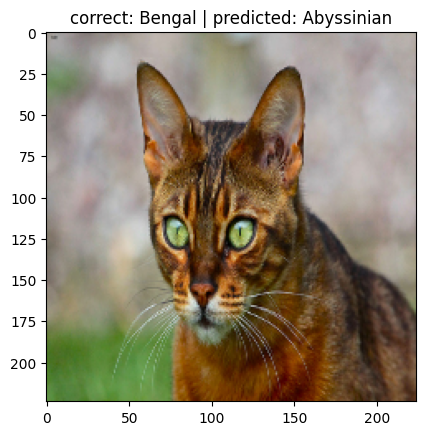

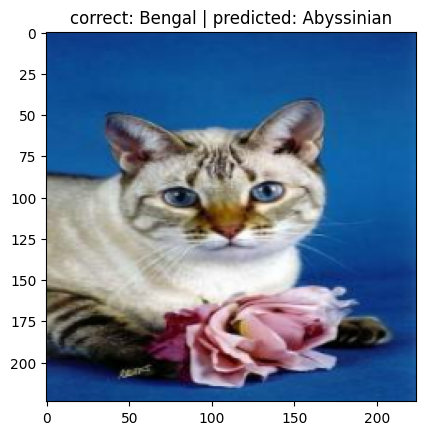

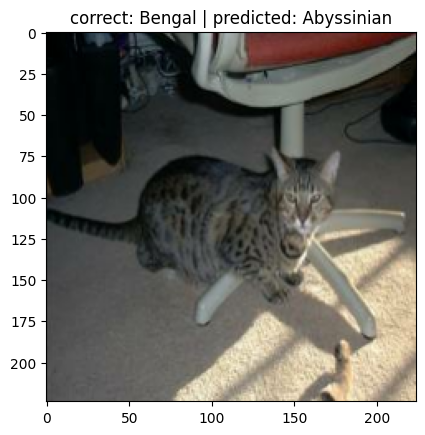

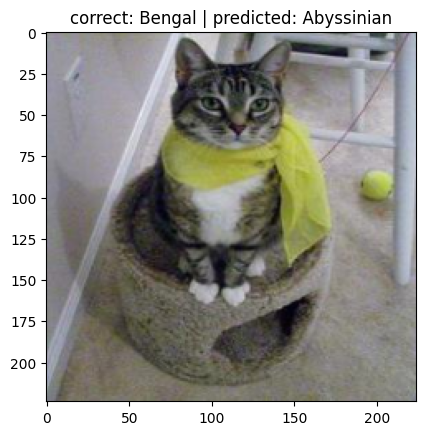

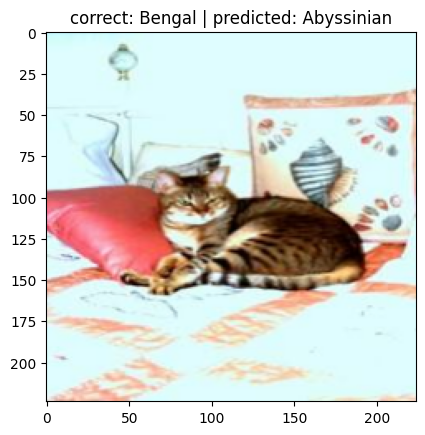

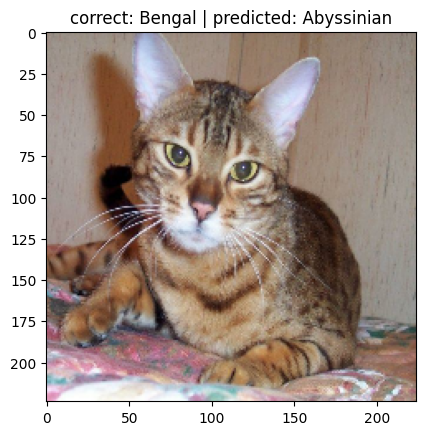

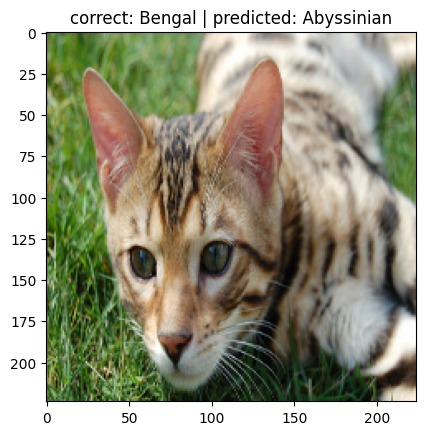

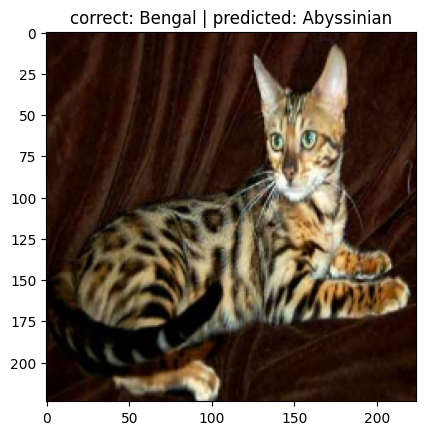

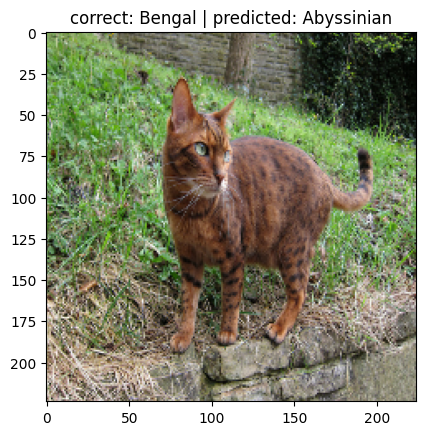

In [42]:
for im,label,pred in zip(images,labels,preds):
  plt.imshow(im.numpy().astype('uint8'))
  plt.title(f'correct: {test_ds.class_names[label]} | predicted: {test_ds.class_names[np.argmax(pred)]}')
  plt.show()